# Project Overview

### RQ1 : Transformer Encoder 기반 Machine-Generated Text Detection 방법에서 중요한 토큰이 존재하는가?
- Transformer Encoder based model (i.e. BERT, RoBERTa, etc.)을 사용한 기계 생성 텍스트 탐지에서 중요도가 높은 토큰 탐색

### RQ2 : 중요한 토큰에 마스킹을 적용해 paraphrasing을 적용하면 탐지 성능이 어떻게 변하는가?
- 중요도가 높은 토큰에 paraphrasing 적용한 예제에 대해 탐지 성능 평가

# Import Lib


In [1]:
import os
import json
import random
from typing import List

import numpy as np
import pandas as pd

import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

import datasets
import transformers
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer

import evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score


SEED = 0

c:\Users\ANDLab001\anaconda3\envs\mgtd\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load HC3 Data

## HC3 (Human ChatGPT Comparison Corpus)
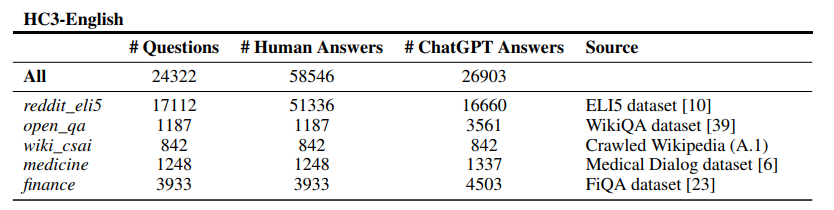

- [How Close is ChatGPT to Human Experts? Comparison Corpus, Evaluation, and Detection](https://arxiv.org/pdf/2301.07597) 논문에서 제안된 데이터셋
- HC3 English 데이터셋은 Finance, OpenQA, Wiki, Medicine, Reddit 과 같은 다양한 도메인의 24,000개의 질문에 대한 인간 및 ChatGPT 응답이 포함


[GitHub]
- https://github.com/Hello-SimpleAI/chatgpt-comparison-detection

In [2]:
def load_hc3(file_path:str) -> datasets.DatasetDict:
    """
    Load HC3 English Dataset to DatasetDict
    """
    data_list = []
    with open(file_path, 'r', encoding = 'utf-8') as file:
        for line in file:
            json_object = json.loads(line.strip())
            data_list.append(json_object)
        
    df = pd.DataFrame(data_list)
    df['human_answers'] = df['human_answers']
    df['chatgpt_answers'] = df['chatgpt_answers']
    
    df_human = {
        'text' : df['human_answers'].to_list(),
        'label' : [0] * len(df['human_answers'].to_list())
    }
    
    df_machine = {
        'text' : df['chatgpt_answers'].to_list(),
        'label' : [1] * len(df['chatgpt_answers'].to_list())
    }
    
    df_human = pd.DataFrame(df_human)
    df_machine = pd.DataFrame(df_machine)
    
    df = pd.concat([df_human, df_machine])
    df = df.reset_index(drop = True)
    
    data = datasets.Dataset.from_dict({'text' : df['text'].to_list(), 'label' : df['label'].to_list()})
    data = data.class_encode_column("label")
    
    return datasets.DatasetDict(data.train_test_split(train_size = 0.8, test_size = 0.2, shuffle = True, stratify_by_column = "label", seed = 0))

In [7]:
# HC3 Finance Dataset
data = load_hc3('./data/HC3/finance.jsonl')
data


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6292
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1574
    })
})

# Train Model

## Implementaion Details
- Model : BERT
- Optimizer : Adam
- Learning Rate : Temp
- Batch Size : Temp
- Epochs : Temp
- GPU : L40S or RTX 3060


In [ ]:
# 수정 예정

class FineTuningHC3(object):
    def __init__(self,
                 base_model_name:str,
                 dataset_name:str,
    ):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.base_model_name = base_model_name
        self.dataset_name = dataset_name
    
    def train_base_model(
        self,
        batch_size:int,
        learning_rate:float,
        epoch:int,
        project_name:str,
    ):
        
        # load base model
        base_tokenizer = AutoTokenizer.from_pretrained(self.base_model_name, max_length = 512, padding = True, truncation = True)
        base_model = AutoModelForSequenceClassification.from_pretrained(self.base_model_name, num_labels = 2).to(self.device)
        
        data = load_hc3(f'./data/HC3/{self.dataset_name}.jsonl')
        
        # tokenized text
        tokenized_data = data.map(lambda examples: base_tokenizer(examples['text'], truncation = True), batched = True)
        data_collator = transformers.DataCollatorWithPadding(tokenizer = base_tokenizer)
        
        # netsted function for compute metrics
        def _compute_metrics(pred):
            labels = pred.label_ids
            preds = pred.predictions.argmax(-1)
            precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average = 'binary')
            acc = accuracy_score(labels, preds)
            auc = roc_auc_score(labels, preds)
            return {
                "accuracy" : acc,
                "f1" : f1,
                "precision" : precision,
                "recall" : recall,
                'auroc' : auc
            }
        
        # define training arguments
        # using AdamW optimizer
        training_args = transformers.TrainingArguments(
            output_dir = f'./results/ft/{self.base_model_name}_HC3_{self.dataset_name}',
            run_name = f'{self.base_model_name}-HC3_{self.dataset_name}',
            per_device_train_batch_size = batch_size,
            per_device_eval_batch_size = batch_size,
            learning_rate = learning_rate,
            weight_decay = 0.01,
            num_train_epochs = epoch,
            evaluation_strategy = "epoch",
            save_strategy = "epoch",
            load_best_model_at_end = True,
            report_to = 'wandb',
            logging_dir = './logs',
            logging_steps = 10,
            seed = 0
        )
        
        trainer = transformers.Trainer(
            model = base_model,
            tokenizer = base_tokenizer,
            args = training_args,
            train_dataset = tokenized_data['train'],
            eval_dataset = tokenized_data['test'],
            data_collator = data_collator,
            compute_metrics = _compute_metrics,
        )
        
        trainer.train()

        
def train_model(base_model_name_list: List, dataset_name_list: List, mask_filling_model_name:str,
                    batch_size:int = 8,
                    epoch:int = 2,
                    learning_rate:float = 1e-4
                    ):
    
    # train base model
    for base_model_name in base_model_name_list:
        for dataset_name in dataset_name_list:
            project_name = f'MGTD-HC3'
            
            torch.cuda.empty_cache()
            mgtd = FineTuningHC3(
                base_model_name = base_model_name,
                dataset_name = dataset_name,
            )
            
            mgtd.train_base_model(
                batch_size = batch_size,
                learning_rate = learning_rate,
                epoch = epoch,
                project_name = project_name,
            )


def test_model(
    test_model_name_or_path:str,
    generate_model_name:str,
    dataset_name:str,
    sample_size: int,
    batch_size: int,
    n_train: int,
    n_test: int,
    prompt_token_len:int,
    gen_max_len:int,
):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    test_data = custom_datasets.load_data(
        f'./data/{dataset_name}_{generate_model_name}_{sample_size}_inputTokenLen_{prompt_token_len}_maxLen_{gen_max_len}.csv',
        n_train = n_train,
        n_test = n_test,
    )
    
    test_dataset = test_data['test']
    
    # load base model and tokenizer
    base_tokenizer = AutoTokenizer.from_pretrained(test_model_name_or_path, max_length = 512, padding = True, truncation = True)
    base_model = AutoModelForSequenceClassification.from_pretrained(test_model_name_or_path, num_labels = 2).to(device)
    
    def tokenize_function(examples):
        return base_tokenizer(examples["text"], padding = "max_length", truncation=True)
    
    test_tokenized_datasets = test_dataset.map(tokenize_function, batched=True)
    test_tokenized_datasets = test_tokenized_datasets.remove_columns(["text"])
    test_tokenized_datasets = test_tokenized_datasets.rename_column("label", "labels")
    test_tokenized_datasets.set_format("torch")
    
    test_dataloader = DataLoader(test_tokenized_datasets, batch_size = batch_size)
    
    metric = evaluate.combine(["accuracy", "recall", "precision", "f1"])
    base_model.eval()
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = base_model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim = -1)
        metric.add_batch(predictions = predictions, references = batch["labels"])

    return metric.compute()

# Find Important Tokens

## Captum / Transformers-Interpret
- PyTorch 기반 기계 해석 라이브러리

### Captum
- https://captum.ai/

### transformers-interpret
- https://github.com/cdpierse/transformers-interpret

### Example
- https://captum.ai/tutorials/Bert_SQUAD_Interpret
- https://github.com/pytorch/captum/blob/master/tutorials/Bert_SQUAD_Interpret.ipynb
- https://github.com/pytorch/captum/issues/303

In [ ]:
# 작성 예정

# Paraphrasing Important Tokens

In [ ]:
# 작성 예정

# Evaluate Paraphrased Texts


In [ ]:
# 작성 예정